# Second algorithm: Train LTSM network based on previously organized data

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle as pkl
import numpy as np
import random

Loading organized dataset and scaler object for the target variable

In [2]:
filehandler = open('dataset_final.pkl', 'rb') 
dataset_final = pkl.load(filehandler)
filehandler.close()
dataset_input_net, dataset_output_net = dataset_final
# dataset_output_net = dataset_output_net.reshape((-1,6))

Initialize seeds for reproducibility and set hyperparameters

In [3]:
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

NUM_EPOCHS = 1000
LEARNING_RATE = 1e-3
DECAY = 1e-5
PATIENCE = 20

Create sequential model consisting of three LSTM layers and two dense layers that continously decrease their size until arrive to 6 outputs corresponding to the shifted version of the target variable 

In [4]:
model = Sequential()
model.add(LSTM(256, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dense(32, activation ='relu'))
model.add(Dense(6, activation ='relu'))

Training the neural net

In [5]:
opt = tf.keras.optimizers.Adam(lr=LEARNING_RATE, decay=DECAY)
model.compile(loss='mse', optimizer=opt, metrics=[tf.keras.metrics.MeanAbsoluteError()])
history = model.fit(dataset_input_net, dataset_output_net, epochs=NUM_EPOCHS, validation_split=0.3,
                    shuffle=True, callbacks = [EarlyStopping(monitor='val_loss', patience=PATIENCE),
                                               ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)])

Train on 13785 samples, validate on 5908 samples
Epoch 1/1000
13785/13785 [==============================] - 18s 1ms/sample - loss: 5.3450e-04 - mean_absolute_error: 0.0104 - val_loss: 2.5209e-04 - val_mean_absolute_error: 0.0075
Epoch 2/1000
13785/13785 [==============================] - 9s 657us/sample - loss: 3.6609e-04 - mean_absolute_error: 0.0084 - val_loss: 2.3851e-04 - val_mean_absolute_error: 0.0065error: 0.00 - ETA: 3s  - ETA: 0s - loss: 3.5885e-04 - mean_absolute_erro
Epoch 3/1000
13785/13785 [==============================] - 9s 661us/sample - loss: 3.2935e-04 - mean_absolute_error: 0.0079 - val_loss: 1.8746e-04 - val_mean_absolute_error: 0.0062
Epoch 4/1000
13785/13785 [==============================] - 9s 662us/sample - loss: 2.7443e-04 - mean_absolute_error: 0.0074 - val_loss: 1.8402e-04 - val_mean_absolute_error: 0.0066
Epoch 5/1000
13785/13785 [==============================] - 9s 663us/sample - loss: 2.5125e-04 - mean_absolute_error: 0.0070 - val_loss: 1.6134e-04 - va

13785/13785 [==============================] - 10s 721us/sample - loss: 2.0085e-04 - mean_absolute_error: 0.0055 - val_loss: 1.3205e-04 - val_mean_absolute_error: 0.0042
Epoch 46/1000
13785/13785 [==============================] - 11s 776us/sample - loss: 2.0243e-04 - mean_absolute_error: 0.0055 - val_loss: 1.4102e-04 - val_mean_absolute_error: 0.0043
Epoch 47/1000
13785/13785 [==============================] - 10s 706us/sample - loss: 2.0608e-04 - mean_absolute_error: 0.0056 - val_loss: 1.5833e-04 - val_mean_absolute_error: 0.0070
Epoch 48/1000
13785/13785 [==============================] - 10s 711us/sample - loss: 2.0211e-04 - mean_absolute_error: 0.0055 - val_loss: 1.3931e-04 - val_mean_absolute_error: 0.0043
Epoch 49/1000
13785/13785 [==============================] - 10s 704us/sample - loss: 2.0185e-04 - mean_absolute_error: 0.0055 - val_loss: 1.4277e-04 - val_mean_absolute_error: 0.0052
Epoch 50/1000
13785/13785 [==============================] - 10s 695us/sample - loss: 2.0117e-

## Save and plot training results

In [6]:
hist_model = history.history
filehandler = open('loss_history.pkl', 'wb') 
pkl.dump(hist_model, filehandler)
filehandler.close()

In [7]:
filehandler = open('loss_history.pkl', 'rb') 
hist_model = pkl.load(filehandler)
filehandler.close()

Loss mean square error (MSE) and mean absolute error (MAE) plots during epochs

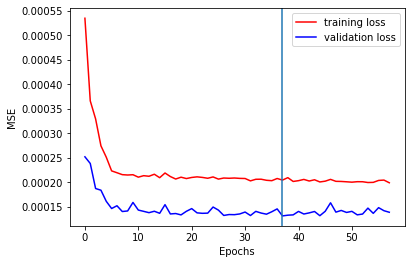

In [8]:
figure = plt.figure()
plt.plot(hist_model['loss'], c='red', label='training loss')
plt.plot(hist_model['val_loss'], c='blue', label='validation loss')
plt.axvline(x=len(hist_model['loss']) - PATIENCE -1)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

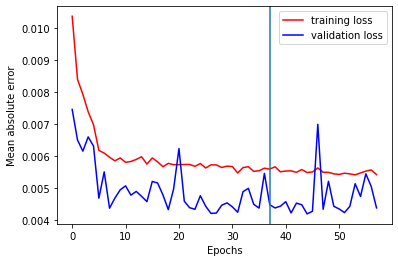

In [9]:
figure = plt.figure()
plt.plot(hist_model['mean_absolute_error'], c='red', label='training loss')
plt.plot(hist_model['val_mean_absolute_error'], c='blue', label='validation loss')
plt.axvline(x=len(hist_model['loss']) - PATIENCE -1)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean absolute error')
plt.show()

Extract MSE and MAE measurements from the best epoch

In [10]:
MSE_train = hist_model['loss'][-(PATIENCE+1)]
MSE_val = hist_model['val_loss'][-(PATIENCE+1)]
MAE_train = hist_model['mean_absolute_error'][-(PATIENCE+1)]
MAE_val = hist_model['val_mean_absolute_error'][-(PATIENCE+1)]
best_model_errors = (MSE_train, MSE_val, MAE_train, MAE_val)

In [11]:
filehandler = open('scaler_final.pkl', 'rb') 
scaler = pkl.load(filehandler)
best_model_errors_transformed = tuple([scaler.inverse_transform(np.array(i).reshape(-1,1)) for i in best_model_errors])
filehandler.close()
print(f'MAE stock_distributed (train): {best_model_errors_transformed[2][0][0]}')
print(f'MAE stock_distributed (validation): {best_model_errors_transformed[3][0][0]}')

MAE stock_distributed (train): 9.657934188842773
MAE stock_distributed (validation): 7.7301554679870605


After inverse-transforming the MAE, we have a pretty good idea about the expected errors at predicting future "stock_distributed" values  